# March Madness Analysis

College basketball fans can better understand the NCAA Tournament by reviewing and analyzing data from previous years. In this report, results from every March Madness game between 1985 and 2016 are analyzed to identify the following trends:
- Expected performance according to seed
- Matchups that often result in exciting games
- Outliers who have exceeded their expectation

This information can be used to identify games that are likely to be interesting, predict winners, or understand a team's tournament history.

## Import Dependencies and Prep Data

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from team_colors_dict import team_colors
plt.style.use('seaborn')

filepath = os.path.join("raw_data", "team_game_level_data.csv")
team_game_df = pd.read_csv(filepath)

# remove play-in games
no_play_ins = team_game_df.loc[team_game_df["round"] != "Opening Round", :]
no_play_ins.head()

,game_id,date,round,region,seed,team,score,opponent_seed,opponent,opponent_score,overtime,score_diff,win,seed_id,year
0,0,1985-03-14,Round of 64,East,1,Georgetown,68,16,Lehigh,43,0,25,1,1_16_fav,1985
1,0,1985-03-14,Round of 64,East,16,Lehigh,43,1,Georgetown,68,0,-25,0,1_16_dog,1985
2,1,1985-03-14,Round of 64,East,4,"Loyola, Illinois",59,13,Iona,58,0,1,1,4_13_fav,1985
3,1,1985-03-14,Round of 64,East,13,Iona,58,4,"Loyola, Illinois",59,0,-1,0,4_13_dog,1985
4,2,1985-03-14,Round of 64,East,5,Southern Methodist,85,12,Old Dominion,68,0,17,1,5_12_fav,1985


# How does each seed typically perform?

Key Takeaways:
- As expected, high seeds generally outperform low seeds.
- There are exceptions, as 9 seeds win fewer games on average than 10 and 11 seeds, and 5 seeds win fewer games on average than 6 seeds.
- When performing a statistical analysis, many seeds' performances are not significantly different than the neighboring seeds. Interestingly, seeds 8-12 do not have a significant difference in average point margin per game.

## Gather Summary Data on Each Seed

In [2]:
# filter data by seed and store
seed_count = 128
avg_wins_by_seed = []
avg_pt_spread_by_seed = []
wins_by_round_by_seed = []

def get_avg_wins(seed):
    games = no_play_ins.loc[no_play_ins["seed"] == seed, :]
    wins = games["win"].sum()
    avg_wins = wins/seed_count
    return avg_wins

def get_avg_pt_spread(seed):
    games = no_play_ins.loc[no_play_ins["seed"] == seed, :]
    avg_pt_spread = games["score_diff"].mean()
    return avg_pt_spread

def get_round_by_round(seed):
    games = no_play_ins.loc[no_play_ins["seed"] == seed, :]
    games_by_round = games.groupby("round")
    wins_by_round = games_by_round["win"].sum()
    return wins_by_round

for seed in range(1,17):
    avg_wins = get_avg_wins(seed)
    avg_wins_by_seed.append(avg_wins)
    avg_pt_spread = get_avg_pt_spread(seed)
    avg_pt_spread_by_seed.append(avg_pt_spread)
    wins_by_round = get_round_by_round(seed)
    wins_by_round_by_seed.append(wins_by_round)

seed_summaries = pd.DataFrame({
    "Seed":range(1,17),
    "Average Wins":avg_wins_by_seed,
    "Average Point Spread": avg_pt_spread_by_seed,
    "Wins by Round": wins_by_round_by_seed
})

seed_summaries = seed_summaries.set_index("Seed")
save_path = os.path.join("raw_data", "seed_summaries.csv")
seed_summaries.to_csv(save_path)
seed_summaries

,Average Point Spread,Average Wins,Wins by Round
Seed,,,
1,11.392193,3.351562,round Elite Eight 52 National Ch...
2,7.109302,2.398438,round Elite Eight 28 National Ch...
3,4.960452,1.796875,round Elite Eight 14 National Ch...
4,3.313846,1.546875,round Elite Eight 13 National Ch...
5,0.892593,1.109375,round Elite Eight 6 National Cha...
6,0.335793,1.125000,round Elite Eight 3 National Cha...
7,-0.585062,0.890625,round Elite Eight 2 National Cha...
8,-3.281818,0.726562,round Elite Eight 5 National Cha...
9,-4.220000,0.562500,round Elite Eight 1 National Semif...


## Compare Average Wins By Seed

As expected, higher seeds generally outperform lower seeds. There are exceptions, as 9 seeds win fewer games on average than 10 and 11 seeds, and 5 seeds win fewer games on average than 6 seeds. When plotted against the number of wins that would be expected if the higher seed won each game, the expected levels of advancement appear to generally hold true.

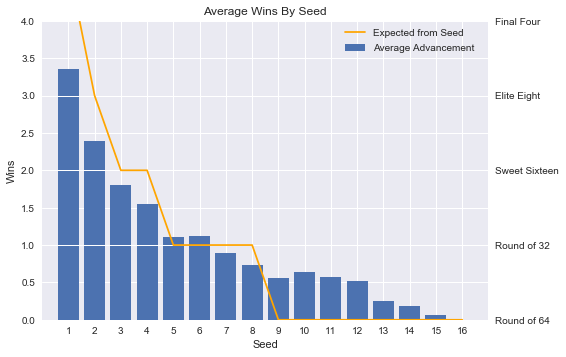

In [34]:
# plot average wins by seed
fig, ax1 = plt.subplots()
plt.title("Average Wins By Seed")

tick_locations = seed_summaries.index
ax1.set_xticklabels(seed_summaries.index)
ax1.set_xlabel("Seed")
ax1.set_ylabel("Wins")
ax1.set_ylim(0,4)
ax1.set_xlim(0,17)

ax2 = ax1.twinx()

ax2.set_ylim(0,4)
ax2.set_xlim(0,17)
ax2.set_xticks(range(1,17))
yticks = ["Round of 64","Round of 32","Sweet Sixteen","Elite Eight","Final Four"]
ax2.set_yticks(range(5))
ax2.set_yticklabels(yticks)

seed_expectations = [4.75,3,2,2,1,1,1,1,0,0,0,0,0,0,0,0]
ax1.bar(seed_summaries.index, seed_summaries["Average Wins"])
ax2.plot(tick_locations, seed_expectations, c="orange")
ax1.legend(["Average Advancement"], loc=(0.67,0.88))
ax2.legend(["Expected from Seed"], loc=(0.67,0.93))
plt.show()

## Compare Average Point Margin by Seed

As expected, high seeds have a better average margin of victory than lower seeds. Only seeds 1-6 have positive average point margins, which can be explained by the single elimination format - teams that lose early on in the tournament do not have an opportunity to improve their point margin. 9 seeds also underperform in this area as they have a poorer point margin than both 10 and 11 seeds.

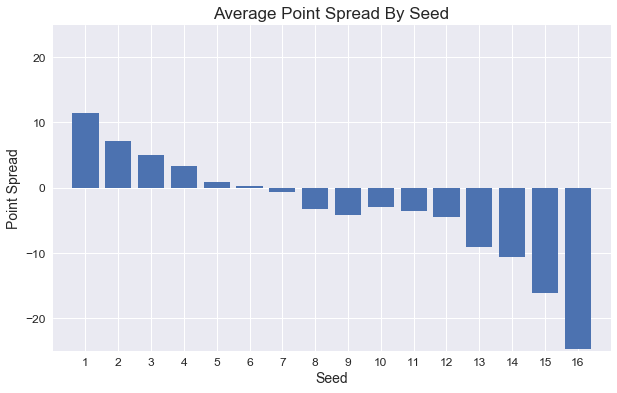

In [4]:
# average point spread by seed
plt.figure(figsize=(10,6))
plt.bar(seed_summaries.index, seed_summaries["Average Point Spread"])
tick_locations = seed_summaries.index
plt.title("Average Point Spread By Seed", fontsize=17)
plt.ylabel("Point Spread", fontsize=14)
plt.xlabel("Seed", fontsize=14)
plt.xticks(tick_locations, seed_summaries.index, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-25,25)
plt.xlim(0,17)
plt.show()

## Typical Tournament Advancement By Seed

The plot below shows the percentage of each seed that advances to each round of the NCAA Tournament. As expected, higher seeds generally outperform lower seeds. There is an interesting trend highlighted in the second plot: while 10-12 seeds are less likely to achieve an upset and advance to the 2nd round, when they do, they are much more likely to win their 2nd round matchup than 8 or 9 seeds. This results in 10, 11, and 12 seeds advancing to the Sweet Sixteen more often than 8 and 9 seeds. This trend can be explained by matchups, and the fact that 8 and 9 seeds that win their first round game must then play a 1 seed in the 2nd round, while 10-12 seeds face easier 2nd round matchups.

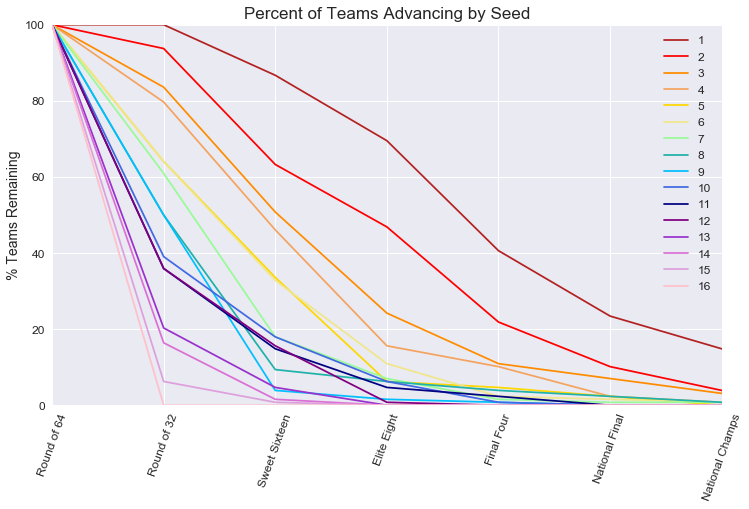

In [5]:
# plot teams remaining by round for each seed
teams_remaining_by_seed = []

def get_wins_in_round(seed_data,tourney_round,seed_count):
    try:
        round_win_pct = (seed_data[tourney_round]/seed_count)*100
    except KeyError:
        round_win_pct = 0
    return round_win_pct

rounds = ["Round of 64","Round of 32", "Sweet Sixteen", "Elite Eight", "National Semifinals", "National Championship"]

for seed in seed_summaries["Wins by Round"]:
    teams_remaining = []
    teams_remaining.append(100)
    for tourney_round in rounds:
        round_win_pct = get_wins_in_round(seed,tourney_round,seed_count)
        teams_remaining.append(round_win_pct)
    teams_remaining_by_seed.append(teams_remaining)
    
colors = ["firebrick","red","darkorange","sandybrown","gold","khaki","palegreen","lightseagreen","deepskyblue","royalblue",
         "navy","purple","darkorchid","orchid","plum","pink"]

plt.figure(figsize=(12,7))
for i in range(len(teams_remaining_by_seed)):
    plt.plot(teams_remaining_by_seed[i], c=colors[i])
    
xticks = ["Round of 64","Round of 32","Sweet Sixteen","Elite Eight","Final Four","National Final","National Champs"]
tick_locations = range(len(xticks))
plt.title("Percent of Teams Advancing by Seed", fontsize=17)
plt.ylabel("% Teams Remaining", fontsize=14)
plt.xticks(tick_locations, xticks, rotation=70, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,100)
plt.xlim(0,6)
plt.legend(range(1,17), fontsize=12)
plt.show()

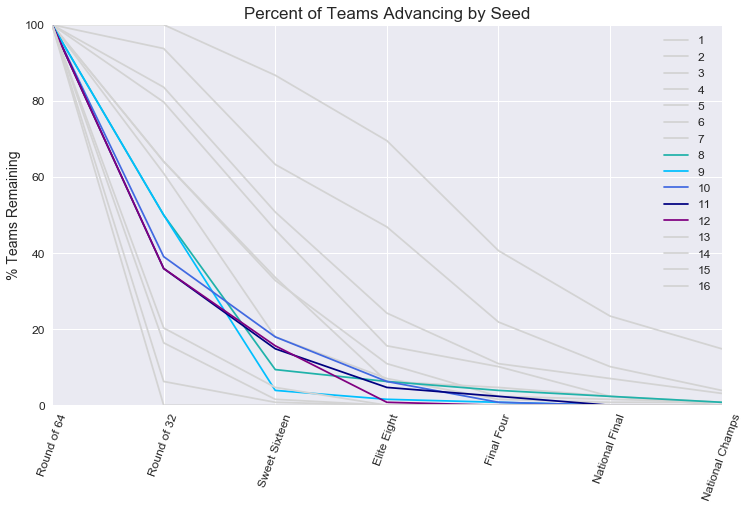

In [6]:
# highlight interesting seeds
    
colors = ["lightgray","lightgray","lightgray","lightgray","lightgray","lightgray","lightgray","lightseagreen",
          "deepskyblue","royalblue","navy","purple","lightgray","lightgray","lightgray","lightgray"]

plt.figure(figsize=(12,7))
for i in range(len(teams_remaining_by_seed)):
    plt.plot(teams_remaining_by_seed[i], c=colors[i])

xticks = ["Round of 64","Round of 32","Sweet Sixteen","Elite Eight","Final Four","National Final","National Champs"]
tick_locations = range(len(xticks))
plt.title("Percent of Teams Advancing by Seed", fontsize=17)
plt.ylabel("% Teams Remaining", fontsize=14)
plt.xticks(tick_locations, xticks, rotation=70, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,100)
plt.xlim(0,6)
plt.legend(range(1,17), fontsize=12)
plt.show()

## Statistical Comparison of Seeds

Below are the results of a statistical comparison of each seeds average point margin. The average point margin for every team of each seed was collected and a paired t-test was performed on each set of seeds to determine if they were significantly different from one another. As expected, seeds far from each other are very different, but neighboring seeds often did not meet the 0.05 threshold to be considered significantly different from one another. This allowed us to group seeds' performance into the following statistically similar and unique sets:
[1, 2, (3, 4), (5, 6, 7), (8, 9, 10, 11, 12), (13, 14), 15, 16]

In [7]:
# statistical comparison of seeds
score_margins_by_seed = []

for seed in range(1,17):
    games = no_play_ins.loc[(no_play_ins["seed"] == seed)]
    score_margins = games["score_diff"]
    score_margins_by_seed.append(score_margins)

seed_comparisons = []
pvals = []
significant_difference = []

for seed in range(15):
    for comparison_seed in range(seed+1,16):
        (statistic, pval) = stats.ttest_ind(score_margins_by_seed[seed], score_margins_by_seed[comparison_seed], equal_var=False)
        if pval < 0.05:
            significant = True
        else:
            significant = False
        seed_comparisons.append(f"{seed+1} and {comparison_seed+1}")
        pvals.append(pval)
        significant_difference.append(significant)
        
seed_comparison_df = pd.DataFrame({
    "Seeds Compared":seed_comparisons,
    "P Value":pvals,
    "Significant Difference":significant_difference
})

similar_seeds = seed_comparison_df.loc[seed_comparison_df["Significant Difference"] == False, :]
similar_seeds

,P Value,Seeds Compared,Significant Difference
29,0.093204,3 and 4,False
54,0.587780,5 and 6,False
55,0.159540,5 and 7,False
65,0.376600,6 and 7,False
84,0.427234,8 and 9,False
85,0.821109,8 and 10,False
86,0.834070,8 and 11,False
87,0.305909,8 and 12,False
92,0.313126,9 and 10,False
93,0.568254,9 and 11,False


In [8]:
similar_pairings = [1,2,(3,4),(5,6,7),(8,9,10,11,12),(13,14),15,16]
similar_pairings

[1, 2, (3, 4), (5, 6, 7), (8, 9, 10, 11, 12), (13, 14), 15, 16]

# Which matchups are most likely to produce upsets?
Key Takeaways:
- There is a linear relationship between absolute seed difference and percentage of upsets in matchups.
- Every game between a 2 and 5 seed has resulted in an upset.
- 40% of games between a 2 and 10 seed has resulted in an upset.

The purpose of this section is to determine which matchups are most likely to produce upsets relative to the absolute seed difference of the teams. Matchups of evenly seeded teams were not considered.

Two dataframes were created to analyze and plot the data.  The first dataframe has one record for each game from the perspective of the underdogs.  This dataframe was used to create a line of best fit to generate the expected upset percentage by absolute seed difference. The second dataframe has one record for each game from the perspective of the winners.  It was used to compare each matchups historical upset percentage to expected upset percentage and plot the data.

The analysis below highlights two subsets of matchups, but the underlying code contains functions that can be used to look at any subset of your choosing.

In [73]:
## Add additional rows to team game dataframe
team_game_df['seed_diff'] = team_game_df['opponent_seed'] - team_game_df['seed']
team_game_df['abs_seed_diff'] = abs(team_game_df['seed_diff'])
team_game_df['matchup'] = [seed_id if len(seed_id)<6 else seed_id[:len(seed_id)-4] for seed_id in team_game_df['seed_id']]

## Create a dataframe with one record for each game from the perspective of the underdogs
under_dog_df = team_game_df[team_game_df['seed'] != team_game_df['opponent_seed']].copy()
under_dog_df['underdog'] = [1 if seed_id[len(seed_id)-3:] == 'dog' else 0 for seed_id in under_dog_df['seed_id']]
under_dog_df = under_dog_df[under_dog_df['underdog'] == 1].copy()
best_fit_array = np.polyfit(under_dog_df['abs_seed_diff'], under_dog_df['win'], deg=1)
under_dog_df['best_fit'] = (best_fit_array[0] * under_dog_df['abs_seed_diff'] + best_fit_array[1]) * 100

## Creates twp data frames
## The first is a dataframe with one record for each game from the perspective of the winners
## The second is a dataframe on the seed matchup level with summary upset data
winner_df = team_game_df[team_game_df['win'] == 1]
winner_df = winner_df[winner_df['seed'] != winner_df['opponent_seed']]
winner_df['upset'] = [1 if seed_id[len(seed_id)-3:] == 'dog' else 0 for seed_id in winner_df['seed_id']]
upsets_groupby = winner_df[['win', 'upset', 'abs_seed_diff', 'matchup']].groupby(['abs_seed_diff', 'matchup'])
upsets_df = upsets_groupby.agg('sum')
upsets_df.columns = ['total_games', 'num_upsets']
upsets_df.reset_index(inplace=True)
upsets_df['upset_perc'] = upsets_df['num_upsets'] / upsets_df['total_games'] * 100
upsets_df['best_fit'] = (best_fit_array[0] * upsets_df['abs_seed_diff'] + best_fit_array[1]) * 100
first_year = 1985
last_year = 2016
total_years = last_year - first_year
upsets_df['games_per_year'] = upsets_df['total_games'] / total_years

In [10]:
## Function to create scatter plot comparing percentage of upset
## and absolute seed difference for all matchup and seed differences
def plot_all_matchups_best_fit(upsets_df, under_dog_df):
    plt.figure(figsize=(12,6))
    matchup_list = list(set(upsets_df['matchup']))
    for i in range(len(matchup_list)):
        matchup = matchup_list[i]
        matchup_df = upsets_df[upsets_df['matchup'] == matchup]
        plt.scatter(matchup_df['abs_seed_diff'], matchup_df['upset_perc'],
                    s=matchup_df['total_games'] * 5, c='#778899',
                    alpha=0.5, edgecolors='black', linewidth=1.5)
        
             linewidth = .5, color = 'black')
    tick_loc = range(1,16)
    plt.xticks(tick_loc)
    plt.title('Percentage of Upsets by Matchup', fontsize=17)
    plt.xlabel('Absolute Seed Difference', fontsize=14)
    plt.ylabel('Percentage of Upsets (%)', fontsize=14)
    legend_data_1, = plt.plot([],[], 'or', markersize = 8, c='#778899', alpha=.5,
                              markeredgecolor = 'black', markeredgewidth =1.5)
    legend_data_2, = plt.plot([],[], 'or', markersize = 20, c='#778899', alpha=.5,
                              markeredgecolor = 'black', markeredgewidth =1.5)
    plt.legend([legend_data_1, legend_data_2],
               ['Few Games', 'Many Games'],
               ncol=1, frameon=True, labelspacing = 1.2, borderpad = 1.2,
               handlelength=2, facecolor = 'white', edgecolor='#181818')

In [57]:
## Function to create scatter plot comparing percentage of upset
## and absolute seed difference to highlight certain seed matchups
def plot_subset_matchups(subset_df, bottom_top_flag, num_matchups, color):
    subset_df['adjusted_upset_perc'] = subset_df['upset_perc'] - subset_df['best_fit']
    subset_df.sort_values('adjusted_upset_perc', ascending=False, inplace=True)
    if bottom_top_flag == 'top':
        plot_df = subset_df.head(num_matchups)
        plot_df = plot_df[plot_df['adjusted_upset_perc'] > 0]
    elif bottom_top_flag == 'bottom':
        plot_df = subset_df.bottom(num_matchups)
        plot_df = plot_df[plot_df['adjusted_upset_perc'] < 0]
    matchup_list = list(set(plot_df['matchup']))
    for i in range(len(matchup_list)):
        matchup = matchup_list[i]
        matchup_df = plot_df[plot_df['matchup'] == matchup]
        plt.scatter(plot_df['abs_seed_diff'], plot_df['upset_perc'], alpha=.5,
                    s=plot_df['total_games'] * 5, c=color, edgecolors=color, linewidth=1.5)

## Relatively high likelihood of upsets for matchups that don't occur often

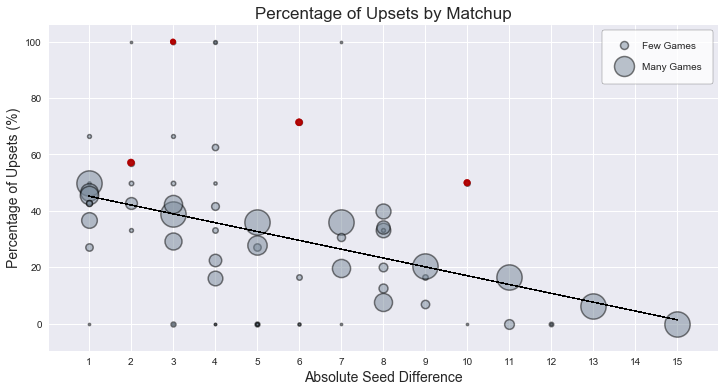

In [68]:
low_freq_df = upsets_df[(upsets_df['total_games'] > 3) & (upsets_df['games_per_year'] < .25)].copy()
plot_all_matchups_best_fit(upsets_df, under_dog_df)
plot_subset_matchups(low_freq_df, 'top', 4, '#B20000')
plt.show()

This subset was defined as matchups that occur less than every four years on average. To eliminate outliers, the matchups also must have occurred at least three times since 1985.  From this subset, the four matchups with the most drastic deviation from expected upset percentage are:

### 2 seed vs 5 seed
- 4 total games
- 100% have been upsets

### 2 seed vs 8 seed
- 7 total games
- 71% have been upsets

### 1 seed vs 11 seed
- 6 total matchups
- 50% have been upsets

### 2 seed vs 4 seed
- 7 total matchups
- 57% have been upsets

## Relatively high likelihood of upsets for matchups that occur every year

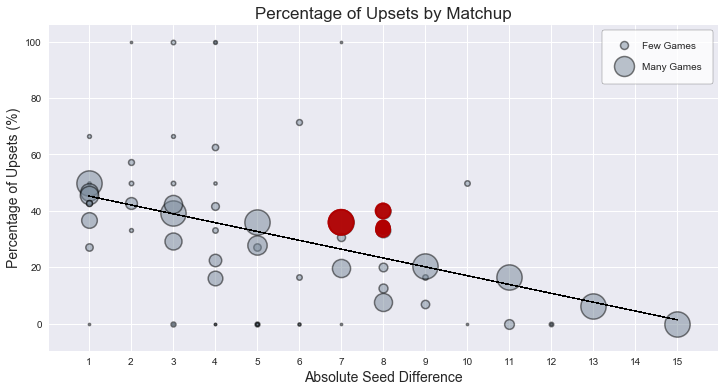

In [72]:
yearly_df = upsets_df[upsets_df['games_per_year'] >= 1].copy()
plot_all_matchups_best_fit(upsets_df, under_dog_df)
plot_subset_matchups(yearly_df, 'top', 4, '#B20000')
plt.show()

This subset was defined as matchups that occur at least once every year on average. The four matchups with the most drastic deviation from expected upset percentage are:

### 2 seed vs 10 seed
- 45 total games
- 40% have been upsets

### 4 seed vs 12 seed
- 35 total games
- 34% have been upsets

### 3 seed vs 11 seed
- 42 total matchups
- 33% have been upsets

### 5 seed vs 12 seed
- 128 total matchups
- 36% have been upsets

# How have individual teams performed in the tournament historically?

Key Takeaways:

- Even the teams that have performed the best historically average less than three wins per tournament.

- Most of the teams that have performed the best historically are schools that most fans would associate with being the best in men's college basketball.

- The average number of wins for a given seed was used to predict the number of "expected wins" for each team based on their seeding for each year.

- Expected wins was used to find teams that have historically over/underperformed.

## Quantifying Team Performance

First, we grouped the results of each game by the teams playing to find the following quantities for each team that has been in the tournament: tournament appearances, games played, games won, win percentage, total point margin, average point margin, average wins per tournament, wins expected based on the historical performance of teams with the same seed, expected games played, deviation from expected wins, and average deviation from expected wins. This information was stored in a dataframe so that the results for individual teams could be accessed and compared.

In [14]:
#Group by team to get all games played by each school in the NCAA tournament
grouped_by_team = no_play_ins.groupby(by="team")

#calculate stats for each team and find "best" in each category
columns = ["Team",
           "Tournament Appearances",
           "Games Played",
           "Games Won",
           "Win Percentage",
           "Total Point Margin",
           "Average Point Margin",
           "Average Number of Wins",
           "Expected Wins",
           "Expected Games Played",
           "Deviation From Expected Wins",
           "Average Deviation From Expected Wins"
          ]
team_performance_summary = pd.DataFrame(columns=columns)
team_count = 0
for team,group in grouped_by_team:
    tournament_appearances = group['year'].nunique()
    games_played = len(group.index)
    games_won = group["win"].sum()
    win_percentage = games_won/games_played
    total_point_margin = (group["score"]-group["opponent_score"]).sum()
    average_point_margin = total_point_margin/games_played
    average_num_wins = games_won/tournament_appearances
    
    #find the seed of team for each tournament appearance
    seeds = [int(group.loc[group.index[0],'seed'])]
    if len(group.index) > 1:
        previous_year = group.loc[group.index[0],'year']
        for index,row in group.iterrows():
            if row["year"] != previous_year:
                seeds.append(int(row['seed']))
            previous_year = row["year"]
    
    #find the number of expected wins and the expected number of games won/played for each tournament based on historical averages
    expected_wins = 0
    expected_games_played = 0
    for seed in seeds:
        expected_wins += float(seed_summaries.loc[int(seed),'Average Wins'])
        expected_games_played += float(seed_summaries.loc[int(seed),'Average Wins']) + 1
    deviation_from_expected_wins = games_won - expected_wins
    deviation_from_expected_wins_average = deviation_from_expected_wins/tournament_appearances
         
    row_to_add = {'Team':team,
                  'Tournament Appearances':tournament_appearances,
                  'Games Played':games_played,
                  'Games Won':games_won,
                  'Win Percentage':win_percentage,
                  'Total Point Margin':total_point_margin,
                  'Average Point Margin':average_point_margin,
                  'Average Number of Wins':average_num_wins,
                  "Expected Wins":expected_wins,
                  "Expected Games Played":expected_games_played,
                  "Deviation From Expected Wins":deviation_from_expected_wins,
                  "Average Deviation From Expected Wins":deviation_from_expected_wins_average
                 }
    team_performance_summary.loc[team_count,:] = row_to_add
    team_count +=1
team_performance_summary.head()

,Team,Tournament Appearances,Games Played,Games Won,Win Percentage,Total Point Margin,Average Point Margin,Average Number of Wins,Expected Wins,Expected Games Played,Deviation From Expected Wins,Average Deviation From Expected Wins
0,Air Force,2,2,0,0,-20,-10,0,0.828125,2.82812,-0.828125,-0.414062
1,Akron,4,4,0,0,-78,-19.5,0,0.914062,4.91406,-0.914062,-0.228516
2,Alabama,15,33,18,0.545455,34,1.0303,1.2,16.8203,31.8203,1.17969,0.0786458
3,Alabama State,2,2,0,0,-69,-34.5,0,0,2,0,0
4,Albany,5,5,0,0,-73,-14.6,0,0.5,5.5,-0.5,-0.1


## Finding the "Top Teams"

We then sorted by the number of tournament appearances to find the schools that had been in the most tournaments since the format was changed to include 64 teams. The results were similar to what we originally expceted them to be and consisted of schools that have a reputation for being good at men's basketball.

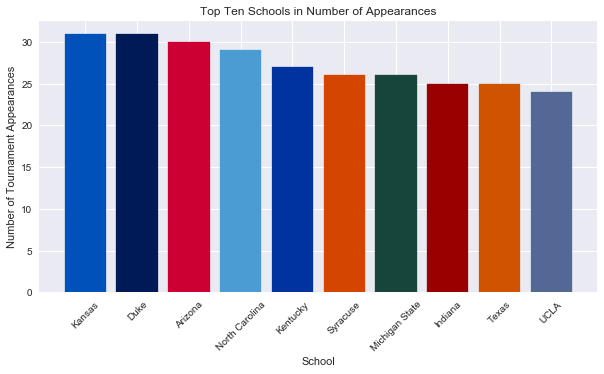

In [15]:
#Most Tournament Appearances
most_appearances = team_performance_summary.sort_values(by="Tournament Appearances",ascending=False).iloc[:10,:]

x = np.arange(len(most_appearances.index))
plt.figure(figsize=(10,5))
barlist = plt.bar(x, most_appearances["Tournament Appearances"])

for i in range(10):    
    team = list(most_appearances['Team'])[i]
    color = team_colors[team]
    barlist[i].set_color(color)
    
plt.xticks(x,list(most_appearances['Team']), rotation=45)
plt.xlabel('School')
plt.ylabel("Number of Tournament Appearances")
plt.title("Top Ten Schools in Number of Appearances")
plt.show()

Next we sorted by the number of games won by schools in the NCAA tournament. This consisted of many of the same teams that were in the top ten for most tournament appearances. It was interesting to see what a large spread there was between the number of wins for Duke which was first in this category and UCLA which was tenth. It also showed that some schools like Conneticut get a lot of wins each time they are in the tournament but don't necessarily make it into as many tournaments as some of the other schools included.

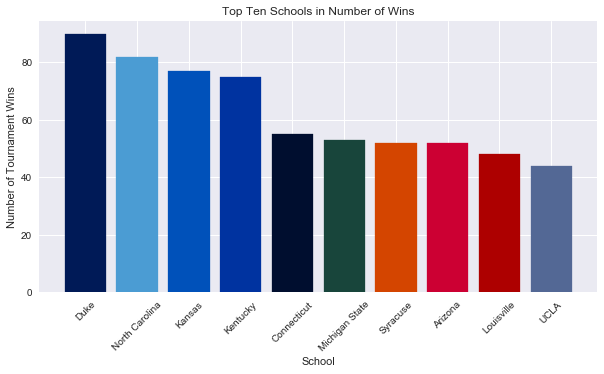

In [16]:
#Most Games Won
most_wins = team_performance_summary.sort_values(by="Games Won",ascending=False).iloc[:10,:]

x = np.arange(len(most_wins.index))
plt.figure(figsize=(10,5))
barlist = plt.bar(x, most_wins["Games Won"])

for i in range(10):    
    team = list(most_wins['Team'])[i]
    color = team_colors[team]
    barlist[i].set_color(color)

plt.xticks(x,list(most_wins['Team']), rotation=45)
plt.xlabel('School')
plt.ylabel("Number of Tournament Wins")
plt.title("Top Ten Schools in Number of Wins")
plt.show()

Finally, we sorted the teams by the net average point spread. Again this mostly consisted of the same teams with just a few exceptions. The fact that Kentucky, Duke and Kansas average almost a positive 10 point victory in every game they play in the tournament was higher than expected.

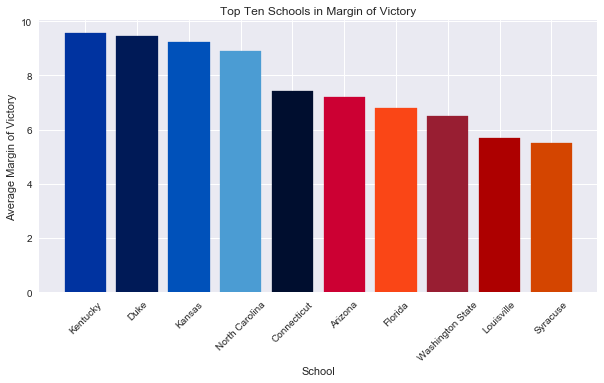

In [17]:
#Best Average Margin of Victory
best_average_point_margin = team_performance_summary.sort_values(by="Average Point Margin",ascending=False).iloc[:10,:]

x = np.arange(len(best_average_point_margin.index))
plt.figure(figsize=(10,5))
barlist = plt.bar(x, best_average_point_margin["Average Point Margin"])

for i in range(10):    
    team = list(best_average_point_margin["Team"])[i]
    color = team_colors[team]
    barlist[i].set_color(color)

plt.xticks(x,list(best_average_point_margin['Team']), rotation=45)
plt.xlabel('School')
plt.ylabel("Average Margin of Victory")
plt.title("Top Ten Schools in Margin of Victory")
plt.show()

## Finding Over and Underperfoming Teams

We plotted the average deviation from the expected number of wins per tournament versus the average  number of wins per tournament to showcase the teams that had overperformed their seeding and had consistently went far in the tournament. The size of the points were based on the number of total games a team has played in the tournament. The large red points on the very right side of the graph represented schools that consistently win a lot of games in the tournament and outperform their seeds. The smaller points in red didn't make as far into the tournament on average, but still overperformed their expected results.

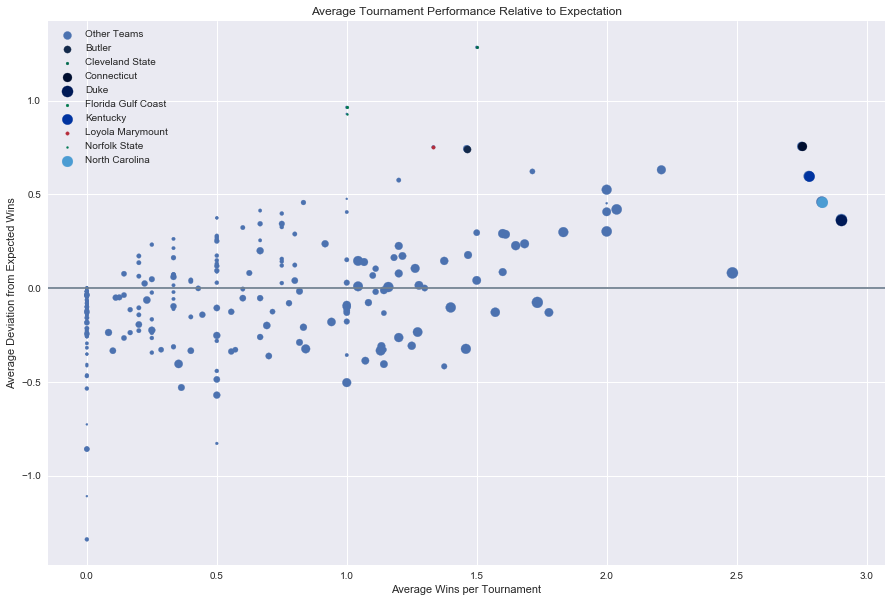

In [18]:
legend_list = []
teams_to_highlight = team_performance_summary.loc[(team_performance_summary.loc[:,'Average Deviation From Expected Wins'] > 0.74)|(team_performance_summary.loc[:,'Average Number of Wins'] > 2.5)]
plt.figure(figsize=(15,10))
plt.scatter(team_performance_summary.loc[:,'Average Number of Wins'],team_performance_summary.loc[:,'Average Deviation From Expected Wins'],s=4*team_performance_summary.loc[:,'Tournament Appearances'].astype('float'),label='Other Teams')
for team in teams_to_highlight['Team']:
    legend_list.append(plt.scatter(teams_to_highlight.loc[teams_to_highlight['Team']==team,'Average Number of Wins'],teams_to_highlight.loc[teams_to_highlight['Team']==team,'Average Deviation From Expected Wins'],s=4*team_performance_summary.loc[team_performance_summary['Team']==team,'Tournament Appearances'].astype('float'),color=team_colors[team],label=team))
plt.xlabel("Average Wins per Tournament")
plt.ylabel("Average Deviation from Expected Wins")
plt.title("Average Tournament Performance Relative to Expectation")
plt.axhline(y=0,color='slategray')
plt.legend()
plt.savefig("Average Tournament Performance Relative to Expectation.png")
plt.show()

This table shows the average number of wins, average deviation from expected wins, games played, and tournament appearances for the teams highlighted in the previous graph. The fact that Duke, North Carolina, Kentucky, and Conneticut had such a high number of wins and often overperformed their seeds was not surprising consider their position on the total number of wins bar graph shown earlier. It was also expected that they wouldn't overperform their seed as often since they are often seeded very high.

It was interesting that there was a team like Butler that almost wins an extra game more than expected every tournament and had a large number of appearances and games played. Their run to the final four a few years ago probably skews this slightly though.

In [19]:
teams_to_highlight.loc[:,['Team','Average Number of Wins','Average Deviation From Expected Wins','Games Played','Tournament Appearances']].sort_values(by='Average Number of Wins',ascending=False)

,Team,Average Number of Wins,Average Deviation From Expected Wins,Games Played,Tournament Appearances
64,Duke,2.90323,0.366179,116,31
169,North Carolina,2.82759,0.460399,108,29
115,Kentucky,2.77778,0.597801,99,27
52,Connecticut,2.75,0.756641,71,20
47,Cleveland State,1.5,1.28516,5,2
28,Butler,1.46154,0.74399,32,13
128,Loyola Marymount,1.33333,0.752604,7,3
77,Florida Gulf Coast,1,0.964844,4,2
168,Norfolk State,1,0.929688,2,1


We plotted the total number of tournament games played versus the total deviation from expected wins. The teams in red are examples that have lots of tournament appearances but don't necessarily perform at the level expected based on their seeding. This trend was harder to show with the previous plot.

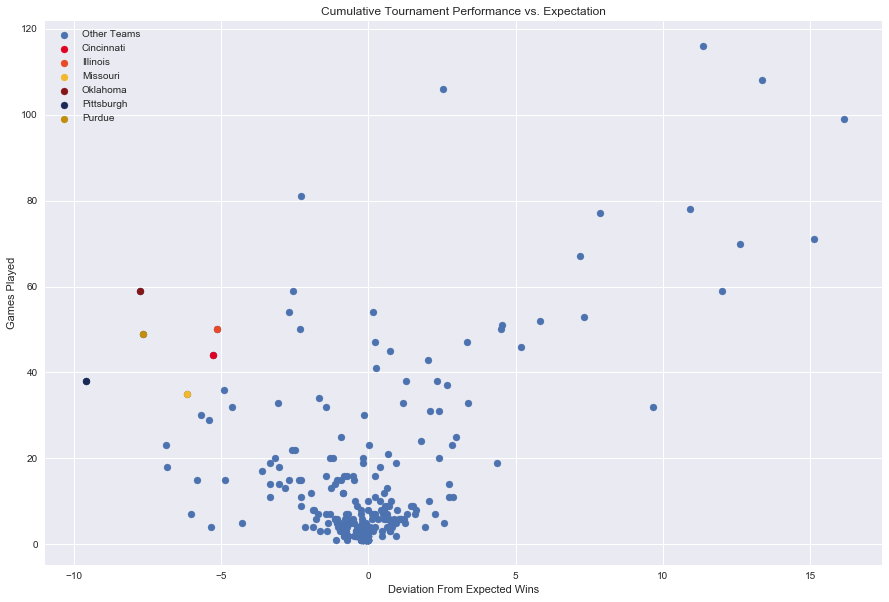

In [20]:
legend_list = []
underperforming_teams = team_performance_summary.loc[(team_performance_summary.loc[:,'Deviation From Expected Wins'] < -5)&(team_performance_summary.loc[:,'Games Played'] > 30)]
plt.figure(figsize=(15,10))
plt.scatter(team_performance_summary.loc[:,'Deviation From Expected Wins'],team_performance_summary.loc[:,'Games Played'],label = 'Other Teams')
for team in underperforming_teams['Team']:
    legend_list.append(plt.scatter(underperforming_teams.loc[underperforming_teams['Team']==team,'Deviation From Expected Wins'],underperforming_teams.loc[underperforming_teams['Team']==team,'Games Played'],color=team_colors[team],label=team))
plt.xlabel("Deviation From Expected Wins")
plt.ylabel("Games Played")
plt.title("Cumulative Tournament Performance vs. Expectation")
plt.legend()
plt.savefig("Cumulative Tournament Performance vs. Expectation.png")
plt.show()

This table shows the average number of wins, average deviation from expected wins, games played, and tournament appearances for the teams highlighted in the previous graph. These teams were more similar in the average number of wins per tournament than was originally expected.

In [21]:
underperforming_teams.loc[:,['Team','Average Number of Wins','Average Deviation From Expected Wins','Games Played','Tournament Appearances']].sort_values(by='Average Number of Wins',ascending=False)

,Team,Average Number of Wins,Average Deviation From Expected Wins,Games Played,Tournament Appearances
188,Oklahoma,1.45833,-0.323568,59,24
101,Illinois,1.27273,-0.23402,50,22
45,Cincinnati,1.2,-0.263281,44,20
204,Purdue,1.13043,-0.33288,49,23
198,Pittsburgh,1,-0.503701,38,19
150,Missouri,0.842105,-0.323602,35,19
